In [1]:
import os
import sys
from IPython.display import Markdown, display, Image
import numpy as np
import pandas as pd
import random
import math
import dvc.api
import time
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

sns.set()

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import data_exploration as de
from utils import *
import store_data_cleaning as sdc
import train_data_cleaning as tdc
from plots import *
import preprocessing as pp
import data_transforming as tr
import training as trn
import testing as ts
import split_dataset as spd
import feature_importance as fi


In [3]:
# instantiate preprocessing class

preprocess = pp.Preprocessing()

In [4]:
df_clean_train = get_data_frame_from_dvc('data/rossmann-store-sales/cleaned_train.csv')
df_clean_store = get_data_frame_from_dvc('data/rossmann-store-sales/cleaned_store.csv')


### Preprocess the data

In [5]:

preprocessed_data = preprocess.preprocess_data(df_clean_train, df_clean_store, True)

### Train the model

In [6]:

X_train, X_test, y_train, y_test = spd.SplitDataset(preprocessed_data).split_dataset()

pipeline, model =  trn.Training(X_train, y_train, 'store_sales_model', preprocessed_data).train()



2022/05/28 09:27:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/28 09:27:31 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                          ...`
2022/05/28 09:27:31 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                                 ['Competiti...`
2022/05/28 09:27:31 WARNING mlflow.utils: Truncated

### Evaluate the model

In [7]:


score, loss, output = ts.Testing(model, X_test, y_test).test()
print(f'SCORE: {score}') 
print(f'MEAN ABSOLUTE ERROR: {loss}')
output.head()

INFO:root:R2 score: {score_2:.3f}
INFO:root:Mean Absolute Error: {loss:.3f}


SCORE: 0.7472923397097115
MEAN ABSOLUTE ERROR: 1084.4155693860478


,Prediction,Actual
Day,,
1,7678.705305,8048.443658
2,7616.924418,8046.926917
3,7623.732958,7796.848607
4,7589.789213,7754.648963
5,7475.682617,7622.621665


<h3 style='font-style:italic'> Observation: 
The prediction has an accuracy of around 0.737 </br>
I used mean absolute error as a loss function since it is less sensitive to outliers.
</h3>


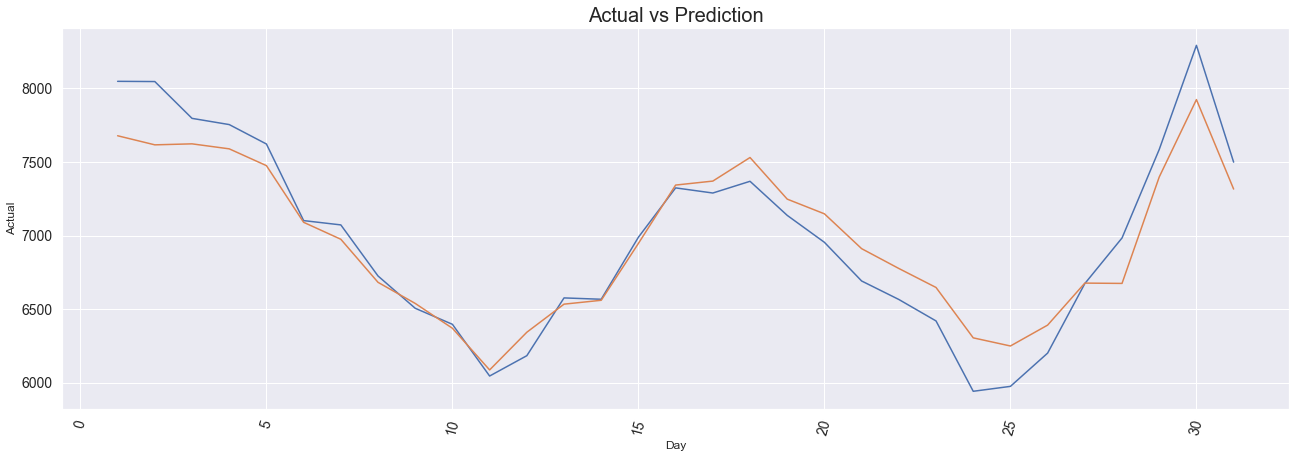

In [8]:
plot_multi_line(output, output.index, output['Actual'], output['Prediction'] , 'Actual vs Prediction') 

In [9]:
timestamp = time.time()
write_model(f"random_forest_model-{timestamp}", model)

INFO:root:Model dumped to random_forest_model-1653719263.760651.pkl


### Post Prediction analysis

In [10]:
feat_imp_calc = fi.FeatureImportance(X_train, model).feature_importance().sort_values(by=["importance"], ascending=False)

feature_importances = pipeline['regressor'].feature_importances_
feat_imp_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=['importance'])
sorted_feat_imp_df = feat_imp_df.sort_values(by=['importance'], ascending=False)

In [11]:
feat_imp_calc.reset_index(drop=True)

,feature,importance
0,DayOfWeek,0.274602
1,Year,0.181611
2,CompetitionOpenSinceYear,0.097416
3,Promo2,0.087158
4,SchoolHoliday,0.068699
5,Promo,0.054056
6,CompetitionDistance,0.047271
7,Promo2SinceYear,0.038305
8,Weekends,0.036393
9,CompetitionOpenSinceMonth,0.036068


#### Calculated

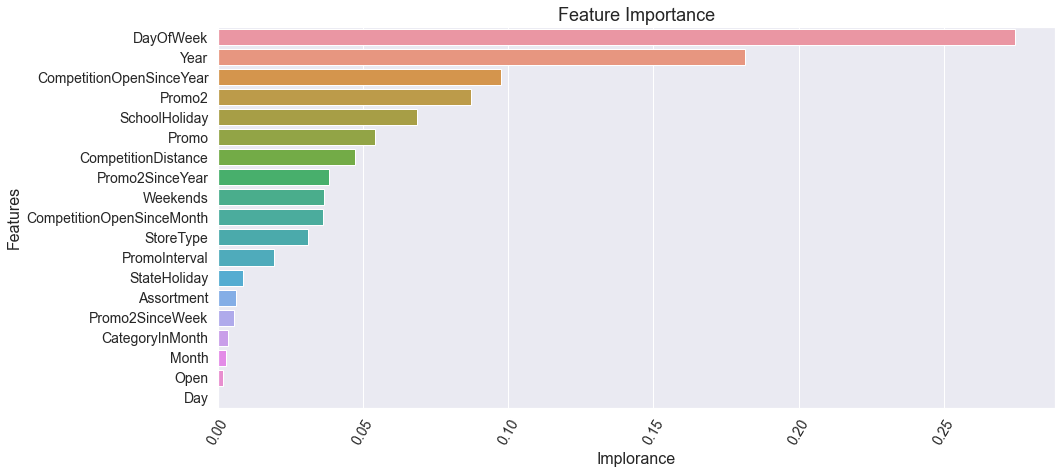

In [12]:
plot_bar(feat_imp_calc,feat_imp_calc['importance'],feat_imp_calc['feature'], 'Feature Importance', 'Implorance', 'Features') 


#### Default method

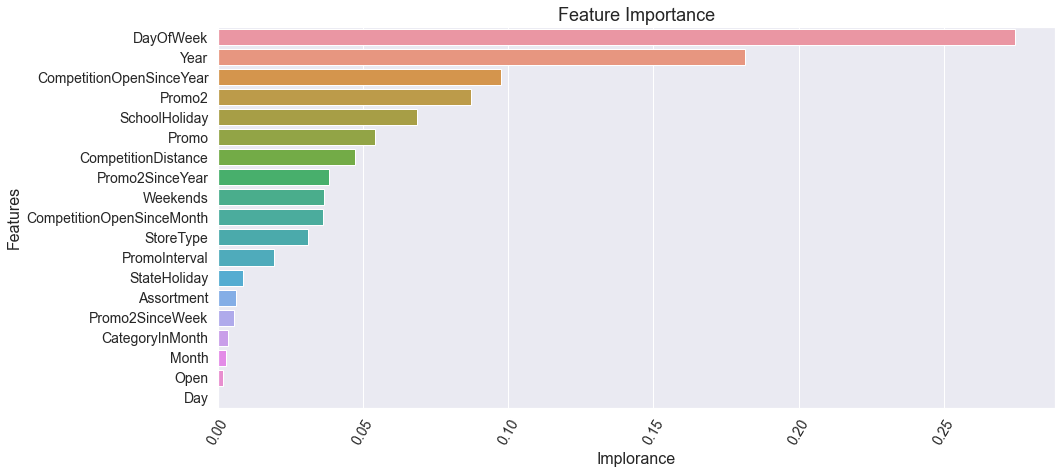

In [13]:
plot_bar(sorted_feat_imp_df, sorted_feat_imp_df['importance'],sorted_feat_imp_df.index, 'Feature Importance', 'Implorance', 'Features') 

<h3 style='font-style:italic'> Observation: 
Important feature for the model is DayOfWeek </br>
Value changes to these feature has the most impact on the model.
</h3>
